In [28]:
import sys
sys.path.append('/host/d/Github')
import os
import numpy as np
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import Osteosarcoma.functions_collection as ff
import Osteosarcoma.Build_lists.Build_list as Build_list

import radiomics
from radiomics import (
    featureextractor,  # This module is used for interaction with pyradiomics
)

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [127]:
from tkinter import font
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_true, y_prob, figsize=(6,6), title = "ROC curve", save_true = False, save_path = None):

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {auc:.3f})')
    plt.plot([0,1], [0,1], '--', lw=1)   # random guess line
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate", fontsize = 13)
    plt.ylabel("True Positive Rate" , fontsize = 13)
    plt.title(title , fontsize = 14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    if not save_true:
        plt.show()
    if save_true and save_path is not None:
        plt.savefig(save_path)

### patient split

In [ ]:
split_out_path = '/host/d/Data/Habitats/Jishuitan/Patient_lists/labels_with_image_info_included_5fold.xlsx'
if os.path.exists(split_out_path):
    print("File exists:", split_out_path)
else:
    # 1) load
    df = pd.read_excel('/host/d/Data/Habitats/Jishuitan/Patient_lists/labels_with_image_info_included.xlsx')

    label_col = "Pathologic_Response_Necrosis_gt90pct"
    y = df[label_col].astype(int).values  # 确保是0/1

    # 2) stratified 5-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    df["fold"] = -1
    for fold_id, (_, val_idx) in enumerate(skf.split(df, y)):
        df.loc[val_idx, "fold"] = fold_id

    # 3) quick check: each fold label ratio
    summary = (
        df.groupby("fold")[label_col]
        .agg(["count", "sum", "mean"])
        .rename(columns={"sum": "n_pos", "mean": "pos_ratio"})
    )
    print(summary)

    out_path = "/host/d/Data/Habitats/Jishuitan/Patient_lists/labels_with_image_info_included_5fold.xlsx"
    df.to_excel(out_path, index=False)
    print("Saved:", out_path)

      count  n_pos  pos_ratio
fold                         
0        17      5   0.294118
1        16      4   0.250000
2        16      4   0.250000
3        16      4   0.250000
4        16      4   0.250000
Saved: /host/d/Data/Habitats/Jishuitan/Patient_lists/labels_with_image_info_included_5fold.xlsx


### load data

In [93]:
labels_path = '/host/d/Data/Habitats/Jishuitan/Patient_lists/labels_with_image_info_included_5fold.xlsx'
radiomics_path = '/host/d/projects/Habitats/radiomics/radiomics_measurements_XGBoost_selected.xlsx'

labels_df = pd.read_excel(labels_path)
radiomics_df = pd.read_excel(radiomics_path)

non_feature_cols = ["Patient_index", "Image_filepath", "Mask_filepath"]
feature_cols = [c for c in radiomics_df.columns if c not in non_feature_cols]
X_all = radiomics_df[feature_cols].values

label_col = 'Pathologic_Response_Necrosis_gt90pct'
y_all = labels_df['Pathologic_Response_Necrosis_gt90pct'].values
fold_all = labels_df['fold'].values
print(f'Feature matrix shape: {X_all.shape}', f'Label vector shape: {y_all.shape}', f'Fold vector shape: {fold_all.shape}')

Feature matrix shape: (81, 13) Label vector shape: (81,) Fold vector shape: (81,)


### model 1: Logistic regression

In [128]:
from sklearn.linear_model import LogisticRegression

out_dir = "/host/d/projects/Habitats/models/LR"
os.makedirs(out_dir, exist_ok=True)


In [77]:
fold_aucs = []

for k in range(5):
    print(f"\n========== Fold {k} ==========")
    
    train_idx = np.where(fold_all != k)[0]
    val_idx   = np.where(fold_all == k)[0]
    print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_val,   y_val   = X_all[val_idx],   y_all[val_idx]

    lr = LogisticRegression(
    penalty="l2",        # Ridge，更稳
    solver="lbfgs",      # L2 推荐 lbfgs
    max_iter=5000,
    )

    lr.fit(X_train, y_train)
   
    # 3.2 predict on val
    prob = lr.predict_proba(X_val)[:, 1]

    # ---- 3.6 AUC
    auc = roc_auc_score(y_val, prob)
    fold_aucs.append(auc)

    print(f"Fold {k} AUC: {auc:.4f}")

    # save the prediction prob into dataframe (use label df as template, we just need to add a new column)
    if k ==0:
        df_preds = labels_df[['Patient_index', 'fold', 'Pathologic_Response_Necrosis_gt90pct']].copy()
        df_preds['pred_prob'] = np.nan
    df_preds.loc[val_idx, 'pred_prob'] = prob

df_preds.to_excel(os.path.join(out_dir, 'predictions.xlsx'), index=False)


========== Fold 0 ==========
Train size: 64, Val size: 17
Fold 0 AUC: 0.8500

========== Fold 1 ==========
Train size: 65, Val size: 16
Fold 1 AUC: 0.7708

========== Fold 2 ==========
Train size: 65, Val size: 16
Fold 2 AUC: 0.9792

========== Fold 3 ==========
Train size: 65, Val size: 16
Fold 3 AUC: 0.6667

========== Fold 4 ==========
Train size: 65, Val size: 16
Fold 4 AUC: 0.6250



Overall AUC across all folds: 0.7802


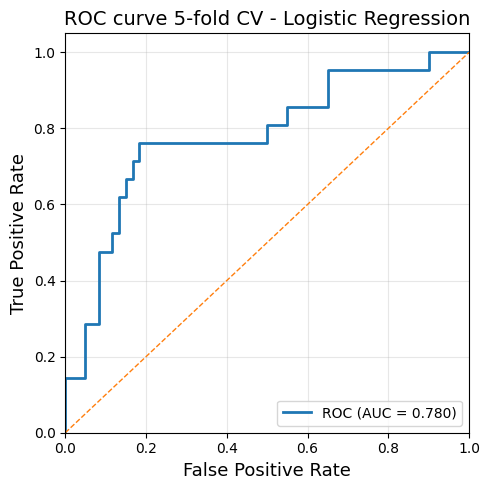

In [129]:
# load the saved predictions and evaluate overall AUC
df_pred = pd.read_excel(os.path.join(out_dir, 'predictions.xlsx'))
y_true = df_pred['Pathologic_Response_Necrosis_gt90pct'].values
y_prob = df_pred['pred_prob'].values
overall_auc = roc_auc_score(y_true, y_prob)
print(f"\nOverall AUC across all folds: {overall_auc:.4f}")
plot_roc_curve(y_true,y_prob, figsize = (5,5),title = "ROC curve 5-fold CV - Logistic Regression", save_true = True, save_path = os.path.join(out_dir, 'ROC_curve_5foldCV_LR.pdf'))

### SVM

In [130]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

out_dir = "/host/d/projects/Habitats/models/SVM"
os.makedirs(out_dir, exist_ok=True)


In [90]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "C":     [0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100]
}

svm = SVC(
    kernel="rbf",
    probability=True,      # 需要输出 predict_proba 才能算 AUC / 画 ROC
    class_weight="balanced"  # 如果你类别不平衡，建议留着；如果平衡可删掉
)

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True,     # 会用最佳参数在全体数据上再 fit 一次
    verbose=1
)

grid.fit(X_all, y_all)

best_params = grid.best_params_
best_auc_cv = grid.best_score_

print("Best params:", best_params)
print("Best mean CV AUC (inner 5-fold on all data):", best_auc_cv)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'C': 100, 'gamma': 0.01}
Best mean CV AUC (inner 5-fold on all data): 0.8308333333333333


In [91]:
best_C = 100 #best_params["C"]  # best C = 10
best_gamma = 0.01 #best_params["gamma"] # best gamma: 0.001

fold_aucs = []

# 用 label df 当模板，保存 out-of-fold prediction
df_preds = labels_df[['Patient_index', 'fold', 'Pathologic_Response_Necrosis_gt90pct']].copy()
df_preds["pred_prob"] = np.nan


for k in range(5):
    print(f"\n========== Outer Fold {k} ==========")

    train_idx = np.where(fold_all != k)[0]
    val_idx   = np.where(fold_all == k)[0]
    print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_val,   y_val   = X_all[val_idx],   y_all[val_idx]

    # 固定超参数训练模型
    svm_fixed = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced"
    )
    svm_fixed.fit(X_train, y_train)

    # validation 预测概率（正类概率）
    prob = svm_fixed.predict_proba(X_val)[:, 1]

    # fold AUC
    auc = roc_auc_score(y_val, prob)
    fold_aucs.append(auc)
    print(f"Fold {k} AUC: {auc:.4f}")

    # 写回 out-of-fold 概率
    df_preds.loc[val_idx, "pred_prob"] = prob

# 保存 out-of-fold 预测
os.makedirs(out_dir, exist_ok=True)
pred_path = os.path.join(out_dir,"predictions.xlsx")
df_preds.to_excel(pred_path, index=False)




========== Outer Fold 0 ==========
Train size: 64, Val size: 17
Fold 0 AUC: 1.0000

========== Outer Fold 1 ==========
Train size: 65, Val size: 16
Fold 1 AUC: 0.9167

========== Outer Fold 2 ==========
Train size: 65, Val size: 16
Fold 2 AUC: 0.9792

========== Outer Fold 3 ==========
Train size: 65, Val size: 16
Fold 3 AUC: 0.6458

========== Outer Fold 4 ==========
Train size: 65, Val size: 16
Fold 4 AUC: 0.5417



Overall AUC across all folds: 0.8198


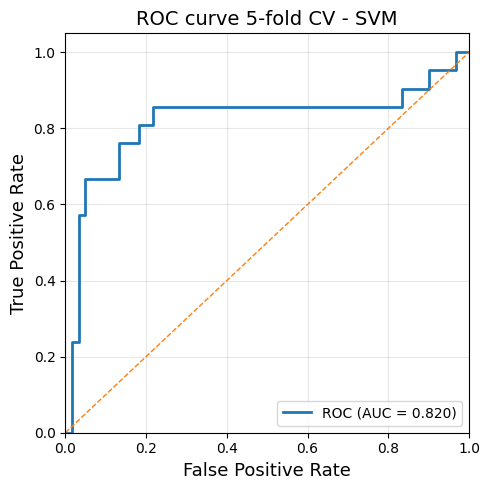

In [131]:
# load the saved predictions and evaluate overall AUC
df_pred = pd.read_excel(os.path.join(out_dir, 'predictions.xlsx'))
y_true = df_pred['Pathologic_Response_Necrosis_gt90pct'].values
y_prob = df_pred['pred_prob'].values
overall_auc = roc_auc_score(y_true, y_prob)
print(f"\nOverall AUC across all folds: {overall_auc:.4f}")

plot_roc_curve(y_true,y_prob, figsize = (5,5),title = "ROC curve 5-fold CV - SVM", save_true = True, save_path = os.path.join(out_dir, 'ROC_curve_5foldCV_SVM.pdf'))

### XGBoost

In [132]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

out_dir = "/host/d/projects/Habitats/models/XGBoost"
os.makedirs(out_dir, exist_ok=True)

In [95]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scale_pos_weight = np.sum(y_all == 0) / np.sum(y_all == 1)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist",     # 快一些；如果你GPU可改成 "gpu_hist"
    random_state=42,
    n_jobs=-1,
    learning_rate = 0.001,
    scale_pos_weight=scale_pos_weight
)

In [56]:
param_grid = {
    "n_estimators": [50, 100,200],
    "max_depth": [3,4,5],}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_all, y_all)

best_params = grid.best_params_
best_auc_cv = grid.best_score_

print("Best params:", best_params)
print("Best mean CV AUC (inner 5-fold on all data):", best_auc_cv)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [07:42:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [07:42:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [07:42:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [07:42:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [07:42:48] WARNING: /w

Best params: {'max_depth': 4, 'n_estimators': 200}
Best mean CV AUC (inner 5-fold on all data): 0.6420833333333332


In [96]:
from tabnanny import verbose

best_n_estimators = 200#best_params["n_estimators"] #200
best_max_depth = 4#best_params["max_depth"] # 4

fold_aucs = []

df_preds = labels_df[['Patient_index', 'fold', label_col]].copy()
df_preds["pred_prob"] = np.nan

for k in range(5):

    train_idx = np.where(fold_all != k)[0]
    val_idx   = np.where(fold_all == k)[0]

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_val,   y_val   = X_all[val_idx],   y_all[val_idx]

    xgb_fixed = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        use_label_encoder=False,
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,   # 仍然用同一个
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        verbose=0
    )

    xgb_fixed.fit(X_train, y_train)

    prob = xgb_fixed.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, prob)
    fold_aucs.append(auc)
    # print(f"Fold {k} AUC: {auc:.4f}")

    df_preds.loc[val_idx, "pred_prob"] = prob

# 保存 out-of-fold 预测
os.makedirs(out_dir, exist_ok=True)
pred_path = os.path.join(out_dir,"predictions.xlsx")
df_preds.to_excel(pred_path, index=False)

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [11:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [11:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [11:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [11:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.10/site-packages/xgboost/training


Overall AUC across all folds: 0.6913


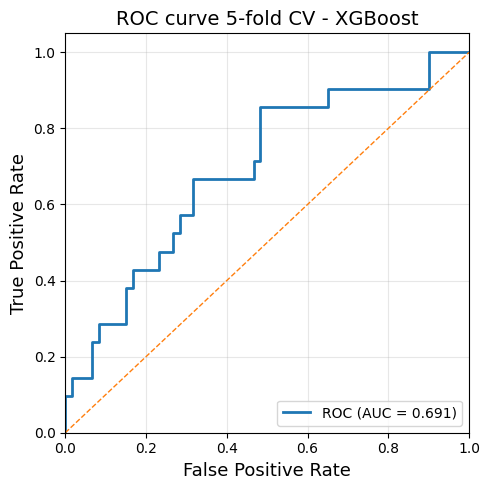

In [134]:
# load the saved predictions and evaluate overall AUC
df_pred = pd.read_excel(os.path.join(out_dir, 'predictions.xlsx'))
y_true = df_pred['Pathologic_Response_Necrosis_gt90pct'].values
y_prob = df_pred['pred_prob'].values
overall_auc = roc_auc_score(y_true, y_prob)
print(f"\nOverall AUC across all folds: {overall_auc:.4f}")

plot_roc_curve(y_true, y_prob, figsize = (5,5),title = "ROC curve 5-fold CV - XGBoost", save_true = True, save_path = os.path.join(out_dir, 'ROC_curve_5foldCV_XGBoost.pdf'))

### Random forest

In [135]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

out_dir = "/host/d/projects/Habitats/models/RandomForest"
os.makedirs(out_dir, exist_ok=True)

In [99]:
import random


best_n_estimators = 200#best_params["n_estimators"] #200
best_max_depth = 4#best_params["max_depth"] # 4

fold_aucs = []

df_preds = labels_df[['Patient_index', 'fold', label_col]].copy()
df_preds["pred_prob"] = np.nan

for k in range(5):

    train_idx = np.where(fold_all != k)[0]
    val_idx   = np.where(fold_all == k)[0]

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_val,   y_val   = X_all[val_idx],   y_all[val_idx]

    random_forest = RandomForestClassifier(
         n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        max_features="sqrt",
        class_weight="balanced",
        random_state=30,
        n_jobs=-1)

    random_forest.fit(X_train, y_train)

    prob = random_forest.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, prob)
    fold_aucs.append(auc)
    # print(f"Fold {k} AUC: {auc:.4f}")

    df_preds.loc[val_idx, "pred_prob"] = prob

# 保存 out-of-fold 预测
os.makedirs(out_dir, exist_ok=True)
pred_path = os.path.join(out_dir,"predictions.xlsx")
df_preds.to_excel(pred_path, index=False)


Overall AUC across all folds: 0.7024


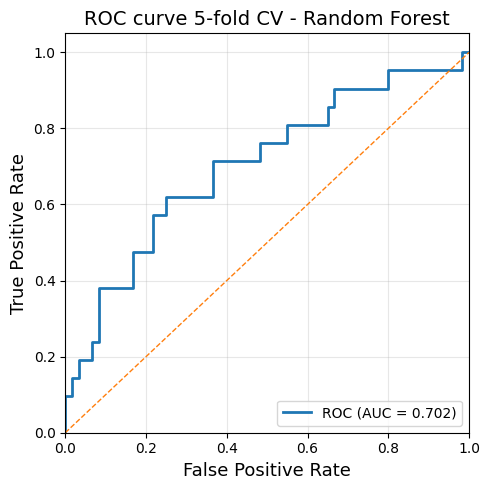

In [136]:
# load the saved predictions and evaluate overall AUC
df_pred = pd.read_excel(os.path.join(out_dir, 'predictions.xlsx'))
y_true = df_pred['Pathologic_Response_Necrosis_gt90pct'].values
y_prob = df_pred['pred_prob'].values
overall_auc = roc_auc_score(y_true, y_prob)
print(f"\nOverall AUC across all folds: {overall_auc:.4f}")

plot_roc_curve(y_true, y_prob, figsize = (5,5),title = "ROC curve 5-fold CV - Random Forest", save_true = True, save_path = os.path.join(out_dir, 'ROC_curve_5foldCV_RandomForest.pdf'))

### Power analysis

In [17]:
import math
from math import erf, sqrt

def norm_cdf(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def se_auc_hanley_mcneil(auc, n1, n0):
    Q1 = auc / (2 - auc)
    Q2 = 2 * auc * auc / (1 + auc)
    var = (auc*(1-auc) + (n1-1)*(Q1-auc*auc) + (n0-1)*(Q2-auc*auc)) / (n0*n1)
    return math.sqrt(var)

def power_auc(N, n_pos, auc_true, auc0=0.5, alpha=0.05):
    # two-sided alpha
    z_alpha = 1.959963984540054  # = norm.ppf(1-alpha/2) for alpha=0.05
    n1 = n_pos
    n0 = N - n1
    se = se_auc_hanley_mcneil(auc_true, n1, n0)
    delta = (auc_true - auc0) / se
    power = 1 - norm_cdf(z_alpha - delta)  # approx for auc_true > auc0
    return power

def required_N_for_power(pos_rate, auc_true, auc0=0.5, alpha=0.05, target_power=0.8,
                         N_min=30, N_max=5000):
    """
    Find the smallest N such that power >= target_power,
    with n_pos = round(pos_rate * N) and n_neg = N - n_pos.
    """
    for N in range(N_min, N_max + 1):
        n_pos = int(round(pos_rate * N))
        # make sure both classes exist
        n_pos = max(1, min(N-1, n_pos))
        pw = power_auc(N, n_pos, auc_true, auc0=auc0, alpha=alpha)
        if pw >= target_power:
            return N, n_pos, pw
    return None, None, None

# ====== your setting ======
pos_rate = 21 / 81   # ~0.259
alpha = 0.05
target_power = 0.8

for auc_true in [0.75, 0.80]:
    for auc0 in [0.5, 0.6, 0.65, 0.7]:
        N_star, npos_star, pw_star = required_N_for_power(
            pos_rate=pos_rate,
            auc_true=auc_true,
            auc0=auc0,
            alpha=alpha,
            target_power=target_power,
            N_min=30,
            N_max=5000
        )
        print(f"AUC_true={auc_true:.2f}, AUC0={auc0:.2f} -> "
              f"required N={N_star}, (npos≈{npos_star}), power≈{pw_star:.3f}")


AUC_true=0.75, AUC0=0.50 -> required N=47, (npos≈12), power≈0.801
AUC_true=0.75, AUC0=0.60 -> required N=126, (npos≈33), power≈0.801
AUC_true=0.75, AUC0=0.65 -> required N=284, (npos≈74), power≈0.802
AUC_true=0.75, AUC0=0.70 -> required N=1133, (npos≈294), power≈0.800
AUC_true=0.80, AUC0=0.50 -> required N=30, (npos≈8), power≈0.835
AUC_true=0.80, AUC0=0.60 -> required N=63, (npos≈16), power≈0.800
AUC_true=0.80, AUC0=0.65 -> required N=110, (npos≈29), power≈0.808
AUC_true=0.80, AUC0=0.70 -> required N=245, (npos≈64), power≈0.803
